In [3]:
import os
import shutil
from glob import glob

import random
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

# 디렉터리로 클래스 분류

In [4]:
train_df = pd.read_csv('./dataset/train_df.csv')
train_df.head()

,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good


In [5]:
train = train_df["file_name"].to_numpy()
target = train_df["label"].to_numpy()

In [6]:
train_path = "./dataset/main_directory/"
test_path = "./dataset/test/"

if not os.path.exists(train_path):
        os.mkdir(train_path)

for label in train_df["label"].unique():
    if not os.path.exists(train_path+label):
        os.mkdir(train_path+label)

for file, label in zip(train,target):
    src = "./dataset/train/"+file
    new_filename = label + '_train_' + file
    dst = os.path.join(train_path,label,new_filename)
    shutil.copy(src, dst)

# 데이터 불러오기

In [7]:
INPUT_SHAPE = (224,224,3)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
def parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img,INPUT_SHAPE[:2])
    return img

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [16]:
classes = os.listdir(train_path)
num_classes = len(classes)
filenames = glob(train_path+'*/*')
num_images = len(filenames)
print(filenames[0].split(os.sep)[-2])
random.shuffle(filenames)
labels = [classes.index(name.split(os.sep)[-2]) for name in filenames]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(
    parse_image,
    num_parallel_calls=AUTOTUNE
)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)

ds = tf.data.Dataset.zip((images_ds, labels_ds))
print(ds.element_spec)
ds = configure_for_performance(ds)
print(ds.element_spec)

bottle-broken_large
(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


(224, 224, 3)
16 255


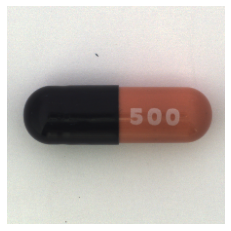

15
capsule-good


In [10]:
for img, label in ds.take(1):
    print(img.numpy()[0].shape)
    img = img.numpy()[0].astype(np.uint8)
    print(img.min(), img.max())
    plt.imshow(img), plt.axis('off')
    plt.show()
    
    print(label.numpy()[0])
    idx = (label.numpy()[0])
    print(classes[idx])

# 데이터 전처리 층만들기
## evaluate() 또는 predict() 호출 시에는 자동으로 비활성화 된다.

In [11]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
])

In [12]:
transfer_model = keras.applications.VGG16(
    input_shape= INPUT_SHAPE,
    include_top= False,
    weights= 'imagenet',
)
transfer_model.trainable = False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
finetune_model = keras.Sequential([
    keras.Input(shape=INPUT_SHAPE),
    data_augmentation,
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    transfer_model,
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax')
],"VGG16")
finetune_model.summary()

finetune_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(learning_rate=0.0002),
                       metrics='accuracy')                    

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 88)                2207832   
                                                                 
Total params: 16,922,520
Trainable params: 2,207,832
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
type(ds)
ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
step = num_images//BATCH_SIZE
tf.random.set_seed(3)

hist = finetune_model.fit(
    ds, epochs=2, steps_per_epoch=step
)

In [ ]:
for i,j in ds.take(2):
    print(j.numpy())